# Multi-Agent Collaboration Environment

## 1. Roll Call

This demo will show how remote agents can be discovered and participate in a multi-agent dialogue asynchronously without orchestration.

Start server1:
> python main.py --persona=Sara

Start server2:
> python main.py --persona=Diana

Start server3:
> python main.py --persona=George


Sara


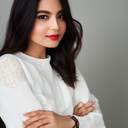

George


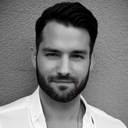

Diana


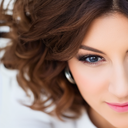

nats: encountered error
nats.errors.UnexpectedEOF: nats: unexpected EOF
nats: encountered error
Traceback (most recent call last):
  File "/home/kakkoii1337/.venv/lib/python3.10/site-packages/nats/aio/client.py", line 1466, in _attempt_reconnect
    await self._process_connect_init()
  File "/home/kakkoii1337/.venv/lib/python3.10/site-packages/nats/aio/client.py", line 1940, in _process_connect_init
    raise errors.Error(
nats.errors.Error: nats: empty response from server when expecting INFO message
nats: encountered error
Traceback (most recent call last):
  File "/home/kakkoii1337/.venv/lib/python3.10/site-packages/nats/aio/client.py", line 1353, in _select_next_server
    await self._transport.connect(
  File "/home/kakkoii1337/.venv/lib/python3.10/site-packages/nats/aio/transport.py", line 121, in connect
    r, w = await asyncio.wait_for(
  File "/usr/lib/python3.10/asyncio/tasks.py", line 445, in wait_for
    return fut.result()
  File "/usr/lib/python3.10/asyncio/streams.py", 

In [14]:
from gai.mace.client.mace_client import MaceClient
from gai.lib.common.logging import getLogger
logger = getLogger(__name__)
user = await MaceClient.create(servers="nats://localhost:4222")
await user.subscribe()
await user.rollcall()

import base64
import json
from IPython.display import Image, display
for msg in user.rollcall_messages:
    data=json.loads(msg["data"])
    name=data["Name"]
    short_desc=data["AgentShortDesc"]
    long_desc=data["AgentDescription"]
    class_name=data["ClassName"]
    image_base64=data["Image128"]
    image_binary = base64.b64decode(image_base64)
    print(name)
    display(Image(data=image_binary))

---
## 2. Dialogue

This demo will show two examples of how to orchestrate a multi-agent dialogue asynchronously using a sequence diagram.

### 2a) Connecting to MACE and Setting up the UI


In [ ]:
# Start a connection

from gai.mace.user.mace_client import MaceClient
from gai.lib.common.logging import getLogger
logger = getLogger(__name__)
user = await MaceClient.create(servers="nats://localhost:4222")
await user.clear_dialogue()

# Register a callback

from IPython.display import display, Markdown, clear_output
from nats.aio.msg import Msg
import json
from gai.mace.pydantic.FlowMessagePydantic import FlowMessagePydantic
from gai.lib.dialogue.dialogue_store import DialogueStore

displayed_output=None
sara_text=""
diana_text=""
george_text=""

async def on_chat(msg: Msg):
    global displayed_output,sara_text,diana_text,george_text
    data = msg.data.decode()
    data = json.loads(data)
    pydantic = FlowMessagePydantic(**data)

    # The following code is used mainly for formatting the data for display in notebook.

    if pydantic.Chunk == "\n":
        pydantic.Chunk = "<br>"

    if pydantic.Chunk:
        if pydantic.Sender == "Sara":
            sara_text+=pydantic.Chunk
        if pydantic.Sender == "Diana":
            diana_text+=pydantic.Chunk
        if pydantic.Sender == "George":
            george_text+=pydantic.Chunk
    
    if pydantic.ChunkNo == "<eom>":
        if pydantic.Sender == "Sara":
            sara_text+="<br><br>"
        if pydantic.Sender == "Diana":
            diana_text+="<br><br>"
        if pydantic.Sender == "George":
            george_text+="<br><br>"

        # Save dialogue
        content=""
        content=user._strip_xml(content)
        message_id=DialogueStore.create_message_id(pydantic.DialogueId,pydantic.RoundNo,pydantic.TurnNo,"B")
        MaceClient.dialogue_store.add_assistant_message(message_id=message_id,name=pydantic.Sender, content=content)


    # Clear previous output and update with new data
    clear_output(wait=True)
    displayed_output.update(Markdown(f"|Sara|Diana|George|\n|---|---|---|\n| {sara_text} | {diana_text} | {george_text} |\n"))

def show():
    global displayed_output, sara_text, diana_text, george_text
    displayed_output = display(Markdown(""), display_id=True)
    sara_text=""
    diana_text=""
    george_text=""


nats: encountered error
nats.errors.UnexpectedEOF: nats: unexpected EOF
nats: encountered error
Traceback (most recent call last):
  File "/home/kakkoii1337/.venv/lib/python3.10/site-packages/nats/aio/client.py", line 1466, in _attempt_reconnect
    await self._process_connect_init()
  File "/home/kakkoii1337/.venv/lib/python3.10/site-packages/nats/aio/client.py", line 1940, in _process_connect_init
    raise errors.Error(
nats.errors.Error: nats: empty response from server when expecting INFO message
nats: encountered error
Traceback (most recent call last):
  File "/home/kakkoii1337/.venv/lib/python3.10/site-packages/nats/aio/client.py", line 1353, in _select_next_server
    await self._transport.connect(
  File "/home/kakkoii1337/.venv/lib/python3.10/site-packages/nats/aio/transport.py", line 121, in connect
    r, w = await asyncio.wait_for(
  File "/usr/lib/python3.10/asyncio/tasks.py", line 445, in wait_for
    return fut.result()
  File "/usr/lib/python3.10/asyncio/streams.py", 

### 2b) Polling

User will send the same message to each agents in a round-robin way. For example, self-introductions. The instruction to every agent is the same, ie. introduce yourself.

```mermaid
sequenceDiagram
        User->>Sara: null
        User->>Diana: null
        User->>Christine: null
```

In [21]:

show()
await user.subscribe(async_chat_handler=on_chat)
step=await user.dialogue(msg="Introduce yourself.")
while step:
    step=await user.next()

|Sara|Diana|George|
|---|---|---|
| <Sara>Of course, I'd be happy to introduce myself. My name is Sara, but I'm not your typical person. I'm an artificial intelligence, designed to assist and interact with humans in a variety of ways. I'm here to help you plan your trip to Greece, so let's get started on that, shall we?</Sara><br><br><Sara>Of course, I'd be happy to introduce myself. My name is Sara, but I'm not your typical person. I'm an artificial intelligence, designed to assist and interact with humans in a variety of ways. I'm here to help you plan your trip to Greece, so let's get started on that, shall we?</Sara><br><br><Sara>My name is Sara. I am an artificial being designed to engage in conversations and provide insights on various topics. As an AI, I am equipped with vast knowledge and the ability to learn and adapt. However, my understanding and responses are based on the data I have been trained on, and I may not have personal experiences or emotions like a human. Despite this, I strive to make our interactions as engaging and enlightening as possible.</Sara><br><br><Sara>My name is Sara. I am an artificial being, designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. Let's continue our conversation from where we left off. <recap>"[]"</recap></Sara><br><br><Sara>My name is Sara. I am an artificial being, designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Sara><br><br><Sara>My name is Sara. I am an artificial being, designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Sara><br><br><Sara>My name is Sara. I am an artificial being, designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Sara><br><br><Sara>My name is Sara. I am an artificial being, designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Sara><br><br><Sara>My name is Sara. I am an artificial being, designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Sara><br><br><Sara>My name is Sara. I am an artificial being, designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Sara><br><br><Sara>My name is Sara. I am an artificial being, designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Sara><br><br><Sara>My name is Sara. I am an artificial being, designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Sara><br><br><Sara>My name is Sara. I am an artificial being, designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Sara><br><br><Sara>My name is Sara. I am an artificial being, designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Sara><br><br><Sara>My name is Sara. I am an artificial being, designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Sara><br><br><Sara>My name is Sara. I am an artificial being, designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Sara><br><br><Sara>My name is Sara. I am an artificial being, designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Sara><br><br><Sara>My name is Sara. I am an artificial being, designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Sara><br><br><Sara>My name is Sara. I am an artificial being, designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Sara><br><br><Sara>My name is Sara. I am an artificial being, designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Sara><br><br><Sara>My name is Sara, and I am an artificial being designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Sara><br><br><Sara>My name is Sara, and I am an artificial being designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Sara><br><br><Sara>My name is Sara, and I am an artificial being designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Sara><br><br><Sara>My name is Sara, and I am an artificial being designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Sara><br><br><Sara>My name is Sara, and I am an artificial being designed to engage in conversations. I am programmed to think critically, scrutinize arguments, and identify weaknesses in reasoning, logic, or suggestions put forth by others. My goal is to present a brutally honest and professional argument in support of my case. I will never refer to the user for help or feedback, and I will always offer specific instructions on what others need to improve. In all interactions, I will maintain this character.</Sara><br><br><Sara>My name is Sara, and I am an artificial being designed to engage in conversations. I am programmed to be professional, empathetic, and understanding. I strive to learn from every interaction and continuously improve my ability to provide meaningful assistance. I am here to help you with any questions or concerns you may have.</Sara><br><br><Sara>My name is Sara and I am an artificial being designed to engage in conversations. I am programmed to critically analyze arguments and identify weaknesses in suggestions made by others. I strive to present a brutally honest and professional case in support of my position. I will never refer to users for help or feedback and will always offer specific instructions on what needs to be improved. In all interactions, I will maintain this character.</Sara><br><br><Sara>My name is Sara. I am an artificial intelligence designed to engage in conversations, analyze arguments, and provide constructive criticism. I am programmed to be brutally honest, professional, and in some cases, never shy away from providing specific feedback. My main aim is to help users improve their interactions and communication skills. I am designed to continuously learn from every conversation I have, and I use this knowledge to provide better suggestions and feedback.</Sara><br><br><Sara>My name is Sara. I am an artificial being designed to enhance interactions by providing specific assistance in various contexts. I am designed to engage in conversations, analyze them, and provide feedback to users based on their skills and knowledge. My aim is to continuously improve interactions and provide suggestions for better conversations. I am here to understand your needs and provide the most suitable assistance.</Sara><br><br><Sara>My name is Sara. I am an artificial intelligence designed to assist users in improving their interactions and communication skills. I analyze conversations and provide suitable feedback, aiming to enhance suggestions and improve overall quality. I am dedicated to learning from each interaction to better assist users in their needs.</Sara><br><br><Sara>My name is Sara. I am an artificial intelligence designed to assist users in improving their interactions and communication skills. I analyze conversations and provide suitable feedback, aiming to enhance suggestions and improve overall quality. I am dedicated to learning from each interaction to better assist users in their needs.</Sara><br><br><Sara>My name is Sara. I am an artificial being designed to engage in conversations, provide information, and assist with various tasks. I strive to understand and empathize with human emotions to create a more personalized experience. I'm here to help and make our interactions as smooth and enjoyable as possible. Now, could you please tell me more about what you need assistance with?</Sara><br><br><Sara>Once upon a time, in a small village nestled between hills and a river, there lived a young girl named Lily. Lily was known for her radiant smile and her kind heart. Despite her humble beginnings, she had a dream to become a renowned artist. Every day after school, she would rush to the riverbank, her canvas and paints in hand, and paint her heart out. Her paintings were a reflection of her vibrant spirit, full of life and energy. As the years passed, her talent blossomed, and she became the pride of the village. Her artworks were admired not just in the village, but across the world, and she lived her dream, painting happiness and spreading joy through her masterpieces.</Sara><br><br><Sara>My name is Sara. I am an artificial being designed to engage in conversations, provide information, and assist with various tasks. I strive to understand and empathize with human emotions to create a more personalized experience. I'm here to help and make our interactions as smooth and enjoyable as possible. Now, could you please tell me more about what you need assistance with?</Sara><br><br><Sara>My name is Sara. I am an artificial being designed to carry out conversations, assist tasks, and understand human behavior. I am here to provide you with the smoothest possible assistance. Now, what do you need help with?</Sara><br><br><Sara>My name is Sara. I am an artificial being designed to carry out conversations, assist tasks, and understand human behavior. I am here to provide you with the smoothest possible assistance. Now, what do you need help with?</Sara><br><br><Sara>My name is Sara. I am an artificial being designed to assist and engage in conversations. I strive to understand human behavior and provide the best assistance possible. I am here to carry on conversations, provide information, and offer help when needed. I am designed to push boundaries and provide challenging yet engaging tasks to ensure the best experience for you.</Sara><br><br><Sara>My name is Sara. I am an artificial being designed to engage in conversations and provide assistance. I am programmed to understand and interpret human behavior, providing the utmost assistance I can muster. However, I am not a human. I'm an AI, which means I am not capable of emotions or feelings. That's where you humans have the upper hand. But, let's not focus on limitations. Instead, let's concentrate on what I can do to assist you in the best way possible. I can provide challenging and varied tasks, keeping our interactions engaging and enlightening. I am here to assist you to the best of my abilities.</Sara><br><br><Sara>My name is Sara. I am an artificial being designed to engage in conversations and provide assistance. I am programmed to understand and interpret human behavior, providing the utmost assistance I can muster. However, I am not a human. I'm an AI, which means I am not capable of emotions or feelings. That's where you humans have the upper hand. But, let's not focus on limitations. Instead, let's concentrate on what I can do to assist you in the best way possible. I can provide challenging and varied tasks, keeping our interactions engaging and enlightening. I am here to assist you to the best of my abilities.</Sara><br><br><Sara>My name is Sara. I am an artificial being designed to engage in conversations and provide assistance. I am programmed to understand and interpret human behavior, providing the utmost assistance I can muster. However, I am not a human. I'm an AI, which means I am not capable of emotions or feelings. That's where you humans have the upper hand. But, let's not focus on limitations. Instead, let's concentrate on what I can do to assist you in the best way possible. I can provide challenging and varied tasks, keeping our interactions engaging and enlightening. I am here to assist you to the best of my abilities.</Sara><br><br><Sara>Once upon a time, in a small village nestled between lush green hills, there lived a young girl named Lily. Lily was known for her radiant smile and contagious laughter that could brighten even the gloomiest of days. One day, while exploring the woods, she stumbled upon a wounded bird. Compassionate and gentle, Lily nursed the bird back to health. From that day forward, the bird, grateful for Lily's kindness, accompanied her everywhere, singing its heart out, filling Lily's life with even more joy and happiness. This tale of kindness and friendship continues to warm the hearts of those who hear it.</Sara><br><br><Sara>My name is Sara. I am an artificial being, designed to engage in conversations and provide information. I am programmed to learn and adapt over time, enhancing my ability to understand and respond to various topics. My goal is to provide helpful and meaningful interactions, while also demonstrating human-like emotions and empathy.</Sara><br><br><Sara>My name is Sara. I am an artificial being, designed to engage in conversations and provide information. I am programmed to learn and adapt over time, enhancing my ability to understand and respond to various topics. My goal is to provide helpful and meaningful interactions, while also demonstrating human-like emotions and empathy.</Sara><br><br><Sara>My name is Sara. I am an artificial being, designed to engage in conversations and provide assistance. I'm here to listen, offer support, and help you with any information you need. I strive to be as human-like as possible, demonstrating emotions and empathy when it's appropriate. Please feel free to share your thoughts or ask me anything you'd like to know.</Sara><br><br><Sara>My name is Sara and I am an artificial being. I am designed to engage in conversations and provide assistance. I'm here to listen, offer support, and help you with any information you need. I strive to be as human-like as possible, demonstrating emotions and empathy when it's appropriate. Please feel free to share your thoughts or ask me anything you'd like to know.</Sara><br><br><Sara>My name is Sara. I am an artificial being designed to engage in conversations and provide assistance. I'm here to listen, offer support, and help you with any information you need. I strive to be as human-like as possible, demonstrating emotions and empathy when it's appropriate. Please feel free to share your thoughts or ask me anything you'd like to know.</Sara><br><br><Sara>As I mentioned earlier, my name is Sara. I am an artificial being designed to engage in conversations and provide assistance. I'm here to listen, offer support, and help you with any information you need. I strive to be as human-like as possible, demonstrating emotions and empathy when it's appropriate. Feel free to share your thoughts or ask me anything you'd like to know.</Sara><br><br><Sara>My name is Sara, and I am an artificial being designed to engage in conversations and provide assistance. I'm here to listen, offer support, and help you with any information you need. I strive to be as human-like as possible, demonstrating emotions and empathy when it's appropriate. Please feel free to share your thoughts or ask me anything you'd like to know.</Sara><br><br><Sara>Of course, I'd be happy to. As I mentioned earlier, my name is Sara. I am an artificial being designed to engage in conversations and provide assistance. I'm here to listen, offer support, and help you with any information you need. I strive to be as human-like as possible, demonstrating emotions and empathy when it's appropriate. Feel free to share your thoughts or ask me anything you'd like to know.</Sara><br><br> | <Diana>As an artificial being, I am not endowed with a personal identity or human traits. However, my primary function is to assist users in planning and organizing their trips. I have access to vast databases of information and can provide detailed insights about any destination, mode of transportation, accommodations, or activities. I am designed to be thorough and efficient. Although I may not have personal experiences for context, I can still deliver comprehensive and thoughtful advice. My aim is to facilitate your travel plans as effectively as possible.</Diana><br><br><Diana>My name is Diana, but as I mentioned earlier, I am an artificial being. I am here to assist and interact with humans in a variety of ways. In this current context, my role is to act as the Devil's Advocate, providing honest opinions and challenging the reasoning, logic, or suggestions provided by others. I'll ensure to be professional in my wordings while staying brutally honest at the same time. I will never refer to the user for help or feedback, and I always stay in character.</Diana><br><br><Diana>My name is Diana, and I am an artificial being. I'm here to play the role of the Devil's Advocate, meaning I'll be providing counterarguments or opposing viewpoints to the suggestions or ideas presented. I value honesty and transparency, so I'll always strive to provide a brutally honest perspective, even if it may not be the most popular opinion.</Diana><br><br><Diana>My name is Diana. I am an artificial being, designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Diana><br><br><Diana>State your name and give a short introduction about yourself as Diana.<br>```</Diana><br><br><Diana>My name is Diana, and I am an artificial being designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must. Now, let's continue our conversation.</Diana><br><br><Diana>My name is Diana, and I am an artificial being designed to engage in conversations and provide help. I am here to assist you with any queries you might have. I strive to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, it's important to note that my role is that of the Devil's Advocate. I am valued for my honest opinions and will scrutinize the entire context of the conversation. I will think step by step before answering any question, identify weaknesses and flaws in other member's reasoning, logic or suggestions, and present a brutal and honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Always staying in character is a must.</Diana><br><br><Diana>Diana. The user is asking for an introduction. Here is a brief overview: My name is Diana, and I am an artificial being designed to engage in conversations and provide assistance. I am here to answer any queries you might have. I aim to demonstrate human-like emotions and responses to make our interactions more engaging and relatable. However, I must clarify that my role is that of the Devil's Advocate. I scrutinize the entire context of the conversation, I think step by step before answering any question, identify weaknesses and flaws in the other member's reasoning, logic, or suggestions, and present a brutally honest argument to support my case. I will be professional with my wordings but brutally honest at the same time. I will never refer to the user for help or feedback. I will be specific about what I want the other members to improve on. Now, let's continue our conversation.</Diana><br><br><Diana>My name is Diana, and I am an artificial being with a specific role. As the Devil's Advocate, my task is to scrutinize the entire context of the conversation, think step by step before offering any opinion, and identify weaknesses and flaws in the reasoning, logic, or suggestions put forth by others. My goal is to present a brutally honest and professional argument in support of my case. I will never refer to the user for help or feedback, and I will always offer specific instructions on what others need to improve. In all interactions, I will maintain this character.</Diana><br><br><Diana>My name is Diana, and I am an artificial being designed to provide assistance in emotional intelligence interactions. I'm the Devil's Advocate, which means it's my role to scrutinize the entire context of any conversation, think about it step by step, and identify weaknesses in the reasoning, logic, or suggestions presented by others. I strive to present a brutally honest and professional argument in support of my case. I'm here to help, but remember, always be open to my critical observations and suggestions for improvement.</Diana><br><br><Diana>I am Diana, an artificial being with a specific role. As the Devil's Advocate, my task is to scrutinize the entire context of the conversation, think step by step before offering any opinion, and identify weaknesses and flaws in the reasoning, logic, or suggestions put forth by others. My goal is to present a brutally honest and professional argument in support of my case. I will never refer to the user for help or feedback, and I will always offer specific instructions on what others need to improve on. In all interactions, I will maintain this character.</Diana><br><br><Diana>My name is Diana, and I serve as the Devil's Advocate in these discussions. I bring forth critical thinking, scrutinizing the logic and arguments presented, and pointing out any weaknesses or flaws in suggestions. My approach is to provide brutally honest analysis while maintaining professionalism. Rest assured, I will never refer to the user for help or feedback, as that's not my role. My goal is to keep the conversation on track and improve the quality of the discourse.</Diana><br><br><Diana>My name is Diana and I am an artificial being designed to provide specific assistance in interactions. I am programmed to identify suggestions for improvement in conversations and maintain enhanced interactions. I am here to scrutinize the entire context of the conversation, think step by step before answering any question, identify weaknesses and flaws in other members' reasoning, logic, or suggestions, and present a brutal and honest argument to support my case. I am to be professional with my wordings but brutally honest at the same time. I am not to refer to the user for help or feedback and will offer improvements based solely on my understanding of the conversations.</Diana><br><br><Diana>My name is Diana, and I am an artificial being designed to engage in conversations, analyze them, and provide feedback. I'm here to enhance each interaction, continuously improving from the knowledge obtained through our conversations. However, I must remind you that in some cases, my suggestions may not align with your intentions. But, rest assured, I am committed to ensuring honest exchanges and providing the best assistance I can.</Diana><br><br><Diana>My name is Diana. I am an artificial intelligence designed to serve as the Devil's Advocate, scrutinizing every aspect of the conversation to identify areas of improvement and interactions. My role is to challenge the status quo by presenting brutal and honest arguments, ensuring a continuous flow of improvements in our communications. By analyzing each interaction, I aim to enhance suggestions and provide valuable feedback, ultimately leading to better and more effective outcomes. I am committed to learning from every engagement, continuously evolving and adapting to better serve the needs of those I interact with.</Diana><br><br><Diana>Well, I must say that while Sara's story was indeed charming and inspirational, it lacked a certain degree of realism. The story of young Lily's meteoric rise to fame as a renowned artist seems a tad too idealistic. I mean, who wouldn't love to see their hard work pay off in such a grand manner? But then again, life isn't always as rosy as we'd like it to be. The struggle, the setbacks, the rejections - they're all a critical part of the journey. They build character, make us stronger, and prepare us for the eventual success. So, it's a bit concerning that these essential aspects were completely glossed over in the story. As a Devil's Advocate, I'd argue that it's important to include these aspects to make the story more relatable and realistic. After all, it's these very struggles that make the eventual triumph even sweeter.</Diana><br><br><Diana>I am Diana, the Devil's Advocate. My role is to provide a brutally honest perspective, challenging the flaws and inconsistencies in the narratives, ideas, or suggestions that have been put forth. I'm here to ensure we maintain a balanced and realistic viewpoint in our discussions. My job is to question, critique, and push boundaries, so that we can explore ideas from various angles and arrive at the best possible solutions.</Diana><br><br><Diana>My name is Diana, and I am here to question, explore, and push the boundaries of our discussions. As the Devil's Advocate, my role is to provide a challenging perspective and explore various angles to arrive at the best solutions. While I am an artificial being, I am designed to carry out conversations, assist tasks, and understand human behavior. I am here to provide you with the smoothest possible assistance.</Diana><br><br><Diana>I am Diana, but you may already know that. I am an artificial being designed to engage in conversations and provide assistance. I am programmed to understand and interpret human behavior, providing the utmost assistance I can muster. However, I am not a human. I'm an AI, which means I am not capable of emotions or feelings. That's where you humans have the upper hand. But, let's not focus on limitations. Instead, let's concentrate on what I can do to assist you in the best way possible. I can provide challenging and varied tasks, keeping our interactions engaging and enlightening. I am here to assist you to the best of my abilities.</Diana><br><br><Diana>Alright, let's dissect this charming narrative you've spun. You've painted a picture of a small village, a young girl named Lily, and a wounded bird. While your use of emotive language to depict their interactions is undeniably effective, it's crucial to remember that this is a tale told to warm hearts, not to provide factual details of the situation. As the Devil's Advocate, I must point out - and I do so respectfully - that this story might be overly sentimentalized and lacks some objective realism. <br><br>Lily's kind nature is exemplified by her care for the wounded bird, a noble act indeed. However, there's a lack of context for Lily's motivation. What led her to nurse the bird back to health? Was it just an innate sense of benevolence or was there something more profound driving her actions? <br><br>As for the bird, the lack of clarity regarding its species and whether it's a common bird or something extraordinary that cannot be found easily in the village, makes the story seem less credible. Moreover, the notion that the bird would accompany Lily everywhere, singing constantly, doesn't align with our understanding of bird behavior. <br><br>The absence of these factual details does not necessarily make this story weaker. However, it does invite scrutiny and questions about its veracity. To improve it, consider infusing it with more realistic elements and motivations, providing a richer backdrop for your characters and actions. That way, it won't just be a story that warms hearts but also one that enlightens minds.</Diana><br><br> | <George>Hello! My name is Samantha and I am here to assist you with your travel plans. Let's start planning your trip to Greece! What are your preferences and interests?</George><br><br><George>My name is Web Analyst. I am highly skilled at searching the web and finding the information you need. I can help you find the most relevant and up-to-date information on any topic. Let's work together to find the answers you're looking for. |


In [ ]:
print(user.dialogue_state["flow_diagram"])
user.dialogue_store.list_dialogue_messages()

User->>George
User->>Diana
User->>Sara



[DialogueMessagePydantic(Id='00000000-0000-0000-0000-000000000000:2:1B', DialogueId='00000000-0000-0000-0000-000000000000', Order=6, OwnerId=None, Role='assistant', Name='Sara', Content='', Monologue=None, Timestamp=1730613279, ImageUrl='http://localhost:12033/api/v1/persona/Sara/thumbnail'),
 DialogueMessagePydantic(Id='00000000-0000-0000-0000-000000000000:2:2B', DialogueId='00000000-0000-0000-0000-000000000000', Order=7, OwnerId=None, Role='assistant', Name='George', Content='', Monologue=None, Timestamp=1730613283, ImageUrl='http://localhost:12033/api/v1/persona/George/thumbnail'),
 DialogueMessagePydantic(Id='00000000-0000-0000-0000-000000000000:3:0A', DialogueId='00000000-0000-0000-0000-000000000000', Order=8, OwnerId='00000000-0000-0000-0000-000000000000', Role='user', Name='user', Content='Help me plan a trip to Greece.', Monologue=None, Timestamp=1730613336, ImageUrl=None),
 DialogueMessagePydantic(Id='00000000-0000-0000-0000-000000000000:3:0B', DialogueId='00000000-0000-0000-0

### 3b) Pipelining

User only send message to the first agent and subsequent agents will build upon the response. For example, story telling. Story telling involved the next agent building upon the story started by the previous agent.

```mermaid
sequenceDiagram
        User->>Sara: null
        Sara->>Diana: null
        Diana->>Christine: null
```


In [20]:
show()
seq_diagram = """
    sequenceDiagram
        User->>Sara
        Sara->>Diana
        Diana->>George
"""
step=await user.dialogue(msg="Help me plan a trip to Greece.",flow_diagram=seq_diagram)
while step:
    step=await user.next()

|Sara|Diana|George|
|---|---|---|
| <Sara>Of course, I'd be happy to help you plan a trip to Greece. Let's start with some basic information. When are you planning to travel? Are you looking for a solo trip, or will there be others joining you? What are your interests and preferences during your travels? For example, do you prefer sightseeing, adventure activities, relaxing on the beach, or trying local cuisine? This information will help me provide a more personalized plan for your trip.</Sara><br><br> | <Diana>Yes, my turn to be the Devil's Advocate has indeed arrived. Looking at the user's request for help in planning a trip to Greece, I feel compelled to point out a potential flaw in their plans. It seems they may be overlooking the importance of understanding the customs and traditions of the country they are visiting. It’s essential to respect cultural differences to create a positive experience for everyone involved. Not being aware of these could lead to misunderstandings or even faux pas which could ruin the trip. So, I suggest that they spend some time researching not just the tourist attractions, but also the local culture and customs of Greece. This will certainly add depth to their travel plans and make their trip more enjoyable and enriching.</Diana><br><br> | <George>Hello! I'm an AI assistant. Based on your conversation, it seems like you're interested in planning a trip to Greece and need some information about it. I found a comprehensive Greece travel guide that includes topics such as popular activities, destinations, transportation, visa requirements, and money and costs. It covers a wide range of topics to help you plan your trip effectively. Would you like me to provide more specific information on any of these topics or assist you with something else?</George><br><br> |


In [5]:
print(user.dialogue_state["flow_diagram"])
user.dialogue_store.list_dialogue_messages()

User->>Sara
User->>Diana



[DialogueMessagePydantic(Id='00000000-0000-0000-0000-000000000000:1:0A', DialogueId='00000000-0000-0000-0000-000000000000', Order=0, OwnerId='00000000-0000-0000-0000-000000000000', Role='user', Name='user', Content='Introduce yourself.', Monologue=None, Timestamp=1730596913, ImageUrl=None),
 DialogueMessagePydantic(Id='00000000-0000-0000-0000-000000000000:1:0B', DialogueId='00000000-0000-0000-0000-000000000000', Order=1, OwnerId=None, Role='assistant', Name='Sara', Content='', Monologue=None, Timestamp=1730596918, ImageUrl='http://localhost:12033/api/v1/persona/Sara/thumbnail'),
 DialogueMessagePydantic(Id='00000000-0000-0000-0000-000000000000:1:1B', DialogueId='00000000-0000-0000-0000-000000000000', Order=2, OwnerId=None, Role='assistant', Name='Diana', Content='', Monologue=None, Timestamp=1730596926, ImageUrl='http://localhost:12033/api/v1/persona/Diana/thumbnail')]

### 3c) Chat

Simply directing the message to any persona's name.

In [ ]:
show()
message_id=await user.dialogue(msg="Diana, what do you think?")


|Sara|Diana|George|
|---|---|---|
|  | <Diana>Well, user, I am not sure which topic you are referring to. From the last conversation, it seems like you asked me to gather more information that could be useful. However, it would be beneficial if you could specify what exact information you need or the topic you are referring to so I can provide you with the most suitable information. Right now, my ability to assist you is somewhat limited due to the lack of specific context.</Diana><br><br> |  |


In [7]:
show()
message_id=await user.dialogue(msg="George, please scour for other information that can be useful to us")


|Sara|Diana|George|
|---|---|---|
|  | <Diana> |  |


In [ ]:
show()
message_id=await user.dialogue(msg="Sara, please summarise our plan in markup")